<a href="https://colab.research.google.com/github/Alinka7/Deep-Learning/blob/main/part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf
# Common
import keras
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from numpy import zeros, random

# Data
from tensorflow.image import resize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Data viz
import matplotlib.pyplot as plt

# Model
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Conv2DTranspose, concatenate, MaxPool2D, Dropout, BatchNormalization, Layer, Input, add, multiply, UpSampling2D

# Model Viz
from tensorflow.keras.utils import plot_model

# Callback
from keras.callbacks import Callback

In [4]:
from glob import glob
root_path = '/content/drive/MyDrive/Colab Notebooks/t/images/'
image_paths = sorted(glob(root_path + f"*.png"))
mask_paths = []
for path in image_paths:
    mask_path = path.replace('images','segmentations')
    mask_path = mask_path.replace('.png','_seg0.png')
    mask_paths.append(mask_path)
print(f"Total Number of Images  : {len(image_paths)}")

Total Number of Images  : 832


In [5]:
def load_image(path):
    img = resize( img_to_array( load_img(path) )/255. , (256,256))
    return img

In [6]:
from numpy import zeros, random
images = zeros(shape=(len(image_paths), 256, 256, 3))
masks = zeros(shape=(len(image_paths), 256, 256, 3))
for n, (img_path, mask_path) in tqdm(enumerate(zip(image_paths, mask_paths)), desc="Loading"):
    images[n] = load_image(img_path)
    masks[n] = load_image(mask_path)

Loading: 832it [09:20,  1.48it/s]


In [7]:
imagesTrain = images[:700]
masksTrain = masks[:700]

imagesTest = images[700:]
masksTest = masks[700:]

In [8]:
train = tf.convert_to_tensor(imagesTrain)
train*=255
train = tf.dtypes.cast(train, tf.uint8)

test = tf.convert_to_tensor(imagesTest)
test*=255
test = tf.dtypes.cast(test, tf.uint8)

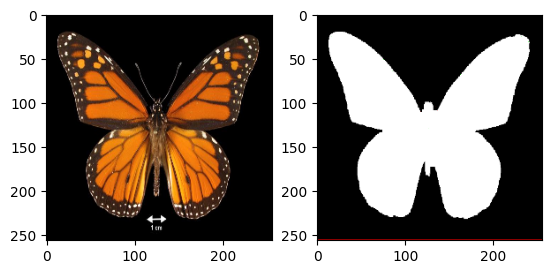

In [9]:
plt.subplot(1,2,1)
plt.imshow(imagesTrain[1])
plt.subplot(1,2,2)
plt.imshow(masksTrain[1])
plt.show()

In [10]:
# this function contains two convolutional layers that are used in the encoder and decoder parts of U-Net
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    # the first conv layer
    x = tf.keras.layers.Conv2D(filters = numFilters,
                               kernel_size = (kernelSize, kernelSize), # size of convolutional kernel 
                               kernel_initializer = 'he_normal', # initialization method for the kernel weights of the layer 
                               padding = 'same') (inputTensor)  # pads the input image with zeros in such a way that the output image has the same spatial dimensions as the input image
                               # as input it takes tensor - input image
    x = tf.keras.layers.BatchNormalization()(x) # normalizing the input of each layer with respect to its mean and variance.
    x =tf.keras.layers.Activation('relu')(x) # activation function relu
    
    # the second conv layer
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1):

    # extract features from the image, thereby reducing the image in height and width but simultaneously growing it in depth
    # (an encoder makes a latent representation for the image)
    # defining encoder Path

    # here we can see that numy filetrs is increased: it is growing it in depth
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3) # creates two 2D-conv layers with kernel 3 
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1) # pooling with the window of size 2
    p1 = tf.keras.layers.Dropout(droupouts)(p1) # randomly sets input tensor elements (10%) to zero
    
    # the same logic
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3) 
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3)
    
    # defining decoder path
    # decode the latent representation
    # increse the size of the image which we get adter encoder
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, #
                                         (3, 3), # kernel size
                                         strides = (2, 2), # the step with which the kernel moves over the input image.
                                         padding = 'same')(c5) # pads the input image with zeros in such a way that the output image has the same spatial dimensions as the input image
    # important moment
    u6 = tf.keras.layers.concatenate([u6, c4]) # join two tensors: result of decoder and encoder, it helps to get more information (because take info from two parts)
                                               # it helps to save more details 
    u6 = tf.keras.layers.Dropout(droupouts)(u6) # randomly sets input tensor elements (10%) to zero
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3) # function of resulted decoder 
    


    # teh same logic
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3)
    
    # resulted layer of one conv layer with 3 filters and kernels of size  

    # У моделі U-Net в останньому шарі використовується функція активації Sigmoid, оскільки вона призводить до виведення значень між 0 і 1, що можна інтерпретувати як ймовірності. Оскільки в U-Net розв'язується задача сегментації зображень, де потрібно виділити області зображення, які містять об'єкти інтересу, функція активації Sigmoid підходить для виведення карт сегментації, оскільки значення пікселів в цих картах можна інтерпретувати як ймовірності належності пікселя до об'єкту інтересу або фону.
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model


In [11]:
#U-Net використовує функцію активації ReLU (Rectified Linear Unit) з двох причин:
# 1. Швидкість навчання: функція ReLU дуже швидка для обчислень, тому вона дозволяє зменшити час навчання мережі.
# 2. Попередження зникнення градієнту: ReLU не має проблеми з зникненням градієнту, яка може виникати з іншими функціями активації, такими як сигмоїда або тангенс гіперболічний. Це допомагає зберігати якість передачі інформації в глибоких мережах.

In [12]:
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [13]:
myTransformer.fit(np.array(imagesTrain), np.array(masksTrain), epochs = 10)

Epoch 1/10
22/22 [==============================] - 735s 33s/step - loss: 0.5278 - accuracy: 0.2522
Epoch 2/10
22/22 [==============================] - 722s 33s/step - loss: 0.3714 - accuracy: 0.2185
Epoch 3/10
22/22 [==============================] - 720s 33s/step - loss: 0.3009 - accuracy: 0.2315
Epoch 4/10
22/22 [==============================] - 722s 33s/step - loss: 0.2634 - accuracy: 0.2215
Epoch 5/10
22/22 [==============================] - 722s 33s/step - loss: 0.2309 - accuracy: 0.2198
Epoch 6/10
22/22 [==============================] - 717s 33s/step - loss: 0.2015 - accuracy: 0.2189
Epoch 7/10
22/22 [==============================] - 704s 32s/step - loss: 0.1831 - accuracy: 0.2168
Epoch 8/10
22/22 [==============================] - 678s 31s/step - loss: 0.1691 - accuracy: 0.2176
Epoch 9/10
22/22 [==============================] - 680s 31s/step - loss: 0.1506 - accuracy: 0.2215
Epoch 10/10
22/22 [==============================] - 677s 31s/step - loss: 0.1344 - accuracy: 0.2221

In [17]:
# function for getting predictions
def predict(valI,valM, model, shape = 256):
    ## getting and proccessing val data
    img = valI
    mask = valM
    mask = mask[0:5]
    
    imgProc = img [0:5]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask
    

    
    
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

In [19]:
prediction, actuals, masks = predict(imagesTest, masksTest,myTransformer)

5/5 [==============================] - 33s 6s/step


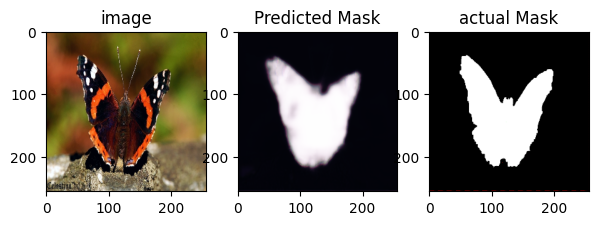

In [20]:
Plotter(actuals[1], prediction[1], masks[1])